# Motivation

Our purpose was to visualize the benefits of trees and to make it more sensible we tried to show it in terms of money. For this purpose, we used 3 different datasets:
1. Foresty Tree Points
2. Eco_benefit
3. New York Geo json dataset

From The *Foresty Tree Points* we found the locations and the conditions of the trees and from *Eco_benefit* we found the money each tree save in four different categories: 
    * Air Pollutants Removed Value In Dollars
    * Co2 Reduced Value In Dollars
    * Energy Conserved Value In Dollars
    * Stormwater Intercepted Value In Dollars
Afterwards, we made a map of New York with Geo json data set and add the points with thier location.


# Basic Stats
**Foresty Tree Points** dataset contains 937403 rows and **Eco benefit** contains **770385** rows. The data has been collected since 2015-02-28 and it contains 516 different tree spices
 
First,  we merge these two datasets by the tree ids. 765773 trees wrere mutual in theese two datasets. Then we choose the column below :
1. Condition 
2. Location
3. Air Pollutants Removed Value In Dollars
4. Co2 Reduced Value In Dollars
5. Energy Conserved Value In Dollars
6. Stormwater Intercepted Value In Dollars
Afterwards, we made three new columns and add them to the data frame:
1. Total: Sum of the money that each tree save
2. Lat: Latitude of points
3. Long: longitude of points

In Addition, there were trees with **unknown** or **nan** conditions, Since the number of them was small we decided to remove those trees. At the end, to make the visualization more clear we sample from the maded dataset.


In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import csv

In [54]:
tree_points = pd.read_csv("Forestry_Tree_Points.csv")
tree_points.head(1)

,treeId,DBH,TPStructure,TPCondition,StumpDiameter,PlantingSpaceGlobalID,Geometry,GlobalID,GenusSpecies,CreatedDate,UpdatedDate,PlantedDate,RiskRating,RiskRatingDate,Location
0,1055852,5.0,Full,Good,0.0,960B0216-AE50-44C0-B79E-369EF6FD0507,POINT (994108.13541689515 148955.26291684806),886F84B2-8720-4F94-984F-2107974C0231,Quercus palustris - pin oak,2015-10-01 13:57:36,NaN,NaN,NaN,NaN,"(40.575518300655716, -73.96451336674765)"


In [7]:
with open('eco-benefits.json') as json_file:  
    eco = json.load(json_file)

In [55]:
eco = pd.DataFrame.from_dict(eco['data'])
eco.head(1)

,airPollutantsRemovedInPounds,airPollutantsRemovedValueInDollars,co2ReducedInPounds,co2ReducedValueInDollars,energyConservedInKwH,energyConservedValueInDollars,stormwaterInterceptedInGallons,stormwaterInterceptedValueInDollars,treeId
0,0.76654637,4.01,321.50000000,1.07,484.73993509,61.20,615.52088116,6.09,2134468


In [9]:
#merging the two data set according to treeID
tree_points.columns = ['treeId','DBH','TPStructure','TPCondition','StumpDiameter','PlantingSpaceGlobalID','Geometry','GlobalID','GenusSpecies','CreatedDate','UpdatedDate','PlantedDate','RiskRating','RiskRatingDate','Location']

merged_df = pd.merge(eco, tree_points, on=['treeId'])

In [56]:
merged_df.head(1)

,airPollutantsRemovedInPounds,airPollutantsRemovedValueInDollars,co2ReducedInPounds,co2ReducedValueInDollars,energyConservedInKwH,energyConservedValueInDollars,stormwaterInterceptedInGallons,stormwaterInterceptedValueInDollars,treeId,DBH,...,PlantingSpaceGlobalID,Geometry,GlobalID,GenusSpecies,CreatedDate,UpdatedDate,PlantedDate,RiskRating,RiskRatingDate,Location
0,0.76654637,4.01,321.50000000,1.07,484.73993509,61.20,615.52088116,6.09,2134468,9.0,...,A043B200-D0D9-4618-AD90-81B3F729B080,POINT (980405.80895856023 200657.05750018358),81EC7288-90FC-44B4-8087-6767F96528A1,Tilia cordata - littleleaf linden,01/05/2016 02:04:06 PM,NaN,NaN,NaN,NaN,"(40.71743316779006, -74.01386751683981)"


In [11]:
#selecting the needed columns from the dataframe
needed_column = merged_df[['TPCondition','Location','airPollutantsRemovedValueInDollars','co2ReducedValueInDollars','energyConservedValueInDollars','stormwaterInterceptedValueInDollars']]

In [15]:
#making two columns lat and long which contains latitude and longitude of locations
temp =  (needed_column['Location'].tolist())

temp = [eval(x) for x in temp]

lat = list(zip(*temp))[0]
long = list(zip(*temp))[1]


needed_column['lat'] = lat
needed_column['long'] = long

In [16]:
#adding a column totals which contains the total money that a tree saves
needed_column['Total']= (needed_column.iloc[:, 2:6].astype(float)).sum(axis=1)

In [57]:
needed_column.head(1)

,TPCondition,Location,airPollutantsRemovedValueInDollars,co2ReducedValueInDollars,energyConservedValueInDollars,stormwaterInterceptedValueInDollars,lat,long,Total
0,Good,"(40.71743316779006, -74.01386751683981)",4.01,1.07,61.20,6.09,40.717433,-74.013868,72.37


In [19]:
# removing trees with unknown condition and also with value nan
needed_column = needed_column.loc[needed_column['TPCondition'] != 'Unknown']

needed_column = needed_column.loc[needed_column['TPCondition'] != 'nan']

filtered_df = needed_column[needed_column['TPCondition'].notnull()]

In [20]:
#sample from the data set
sample = filtered_df.sample(50000)

sample.to_csv(r'/home/elika/uni/social_graph/project/sample50000.csv')

In [44]:
tree_points['CreatedDate'] = pd.to_datetime(tree_points['CreatedDate'])

In [45]:
#finding the start and end date of the data
times  = list(tree_points['CreatedDate'])

print('start date : ' + str(min(times)))

print('finish date : ' + str(max(times)))

start date : 2015-02-28 05:00:00
finish date : 2019-03-29 16:34:31


# Data Analysis

We found the distribution of the conditions by ploting the bar chart and pie chart. moreover, we found the most common tree spices. Additionally, we plot the distributions of trees with ploting heatmaps. also, we calculate the total money that trees save.


## Tree Conditions 

In [21]:
conditions = (tree_points.groupby(['TPCondition']).size()).keys()
values_of_conditions = list(tree_points.groupby(['TPCondition']).size())

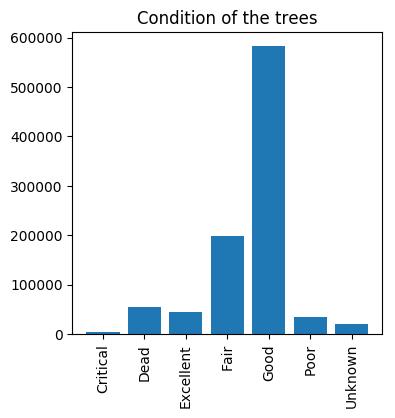

In [58]:

plt.figure(figsize=(4, 4), dpi=100, facecolor='w')
plt.bar(conditions,values_of_conditions)
plt.xticks(rotation=90)
plt.title("Condition of the trees")

plt.show()

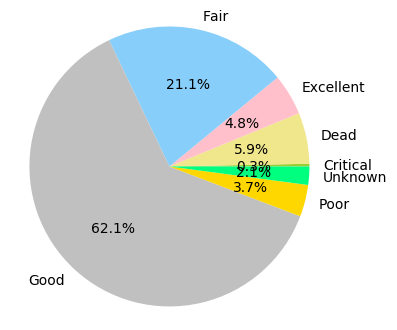

In [59]:
colors = ['yellowgreen', 'khaki','pink' ,'lightskyblue', 'silver','gold', 'springgreen']

plt.figure(figsize=(4, 4), dpi=100, facecolor='w')
plt.pie(values_of_conditions, labels=conditions, colors=colors,autopct='%1.1f%%')

plt.axis('equal')
plt.show()

## Tree Types

In [24]:
tree_types = (tree_points.groupby(['GenusSpecies']).size()).keys()
type_val = list((tree_points.groupby(['GenusSpecies']).size()).keys())

In [39]:
# Most common tree species
spices = (tree_points.groupby(['GenusSpecies']).size()).sort_values(ascending = False)

In [40]:
spices = spices.to_frame()
spices = spices.reset_index()
spices.columns = ['GenusSpecies', 'count']
spices.head(3)

,GenusSpecies,count
0,Platanus x acerifolia - London planetree,110839
1,Gleditsia triacanthos var. inermis - Thornless...,74619
2,Quercus palustris - pin oak,70872


# Add heatmaps here 

## Money

### Dead Trees

In [46]:
dead_trees = merged_df.loc[merged_df['TPCondition'] == 'Dead']

In [47]:
Area = ['airPollutantsRemovedValueInDollars','energyConservedValueInDollars','co2ReducedValueInDollars','stormwaterInterceptedValueInDollars']

In [50]:
for area in Area:
    money = list(dead_trees[area])
    temp = 0
    for i in money:
        try:
            temp = float(i)+temp

        except:
            continue
    print('Total ' + area + '  ' + str(temp))

Total airPollutantsRemovedValueInDollars  291805.9699999622
Total energyConservedValueInDollars  3559840.7100002766
Total co2ReducedValueInDollars  199322.96000001446
Total stormwaterInterceptedValueInDollars  443428.0099999238


### Live Trees

In [52]:
#finding the live trees by removing unknown and Dead trees
live_trees = merged_df.loc[merged_df['TPCondition'] != 'Dead' ]
live_trees = merged_df.loc[merged_df['TPCondition'] != 'Unknown']

In [53]:
for area in Area:
    money = list(live_trees[area])
    temp = 0
    for i in money:
        try:
            temp = float(i)+temp

        except:
            continue
    print('Total ' + area + '  ' + str(temp))

Total airPollutantsRemovedValueInDollars  7086943.709991947
Total energyConservedValueInDollars  89675511.05988549
Total co2ReducedValueInDollars  4430135.069982331
Total stormwaterInterceptedValueInDollars  11454629.74999678


# Genre.
* Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
* Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

# Genre

We used a combination of **Annonated Chart** and **Partitional Poster**, As we want the users to be able to interact with our visualization and also the statistics beside the map add annotations to make it more understandable

**Visual Narrative** : Zooming, Motion

**Narrative Structure** : Filtering / Selection, Annotations


# Visualizations
* Explain the visualizations you've chosen.
* Why are they right for the story you want to tell?

# Visualizations
For the Visualizations we made a map of New york city. Then add the trees coler coded as:
* Green : Excellent and good 
* Yellow : Fair and Critical 
* Red : Dead

The map has the zooming functionality which enables users to zoom on a neighbourhood. Then a bar chart below the map will appear and shows the distributions of the conditions of the trees in that chosen neighbourhood. In addition, the money that is saved by the living tree and the money that could have been saved by the dead trees in that neighbourhood will be shown next to the bar charts


# Discussion
* What went well?,
* What is still missing? What could be improved?, Why?

# Discussion

There was an issue in implementing zooming and brushing Simultaneously, thus, we decided to brush the neighbourhood that is chosen by zooming.

For plotting the Trees, we sampled from the data as it was so slow to have all the points. 

# Contributions
* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
* It is not OK simply to write "All group members contributed equally".
* Make sure that you use references when they're needed and follow academic standards.

# Contributions